## Import and globals

In [1]:
from IO import read_kitty, write_one_kitty
import yaml
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
from torchinfo import summary as info_summary
from itertools import chain, repeat, product, islice
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score

%matplotlib inline
config = yaml.safe_load(open('./net_config.yaml'))
print(*config.items(), sep='\n')

('generator', {'lr': 0.001})
('discriminator', {'lr': 0.001})
('data_loader', {'train': ['11', '12', '13', '14', '15', '16', '17', '18', '20', '22', '23', '24', '26'], 'valid': ['11', '12', '13', '14', '15', '16', '17', '18', '20', '22', '23', '24', '26'], 'test': ['30', '34', '35', '36', '76']})
('run', {'device': 1, 'cuda': True, 'seed': 42})
('train', {'disc_loops': 3, 'batch_size': 1, 'max_epoch': 20, 'log_name': 'test', 'checkpoint': False})
('eval', {'save': 2})


## Build dataloader

In [2]:
def describe_data():
    points, labels = read_kitty(config['data_loader']['train'], max_len=1)
    sample = next(iter(points['11'].values()))
    print('Point cloud shape:', sample.shape)
    print(*sample[:5],sep='\n')
    sample = next(iter(labels['11'].values()))
    print('\nLabel shape:', sample.shape)
    print(*sample[:5],sep='\n')
describe_data()

Point cloud shape: (115881, 4)
[-197.84776     26.662176     3.9865794   13.       ]
[-197.78802     25.835665     2.8061757    6.       ]
[-197.77983     25.658987     1.0338181   10.       ]
[-197.77368     26.125235     2.2110257    9.       ]
[-197.7581      26.23899      3.3880968   13.       ]

Label shape: (115881, 2)
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]


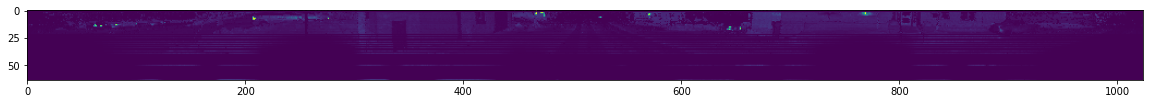

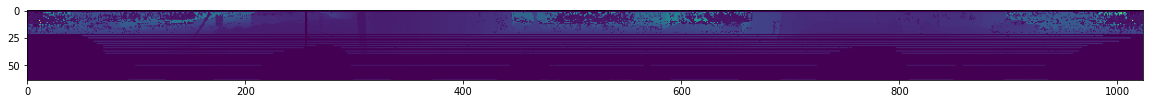

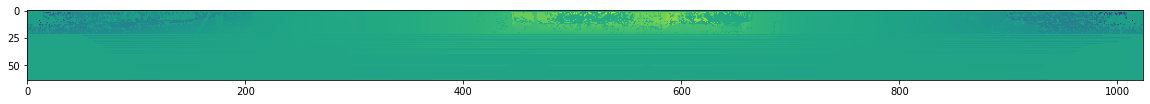

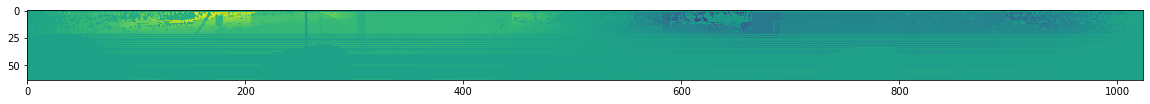

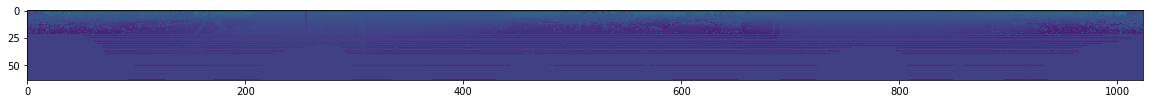

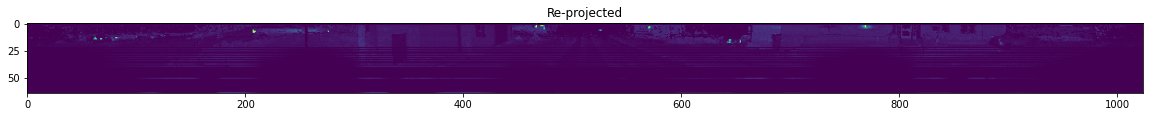

In [3]:
def project(points, vertical_fov:tuple=(3.0,-25.0), out_shape:tuple=(64,1024)):
    # unpack params to short names
    P = points.copy()
    fov_up, fov_down = vertical_fov
    height, width = out_shape
    x, y, z = P[:,0], P[:,1], P[:,2]

    # Compute spherical coordinates
    r = LA.norm(P[:,:3], 2, axis=1)
    yaw = -np.arctan2(y, x)
    pitch = np.arcsin(z / r)
    
    # Parameters of the LiDAR
    fov_up = fov_up / 180.0 * np.pi  # field of view up in rad
    fov_down = fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # field of view total in rad

    # get projections in image coords
    clamp = lambda x,m: np.maximum(0, np.minimum(np.round(x),m)).astype(np.int32)
    
    proj_x = 0.5 * (yaw / np.pi + 1.0)  # in the set [0.0, 1.0]
    proj_x *= width  # in [0.0, W]
    proj_x = clamp(proj_x, width-1) # in [0,W-1]
    
    proj_y = 1.0 - (pitch + abs(fov_down)) / fov  # in the set [0.0, 1.0]
    proj_y *= height  # in [0.0, H]
    proj_y = clamp(proj_y, height-1)  # in [0,H-1]

    # order in decreasing depth
    rev_indices = np.arange(r.shape[0])
    indices = np.argsort(r)[::-1]
    P, proj_y, proj_x = P[indices], proj_y[indices], proj_x[indices]
    r, rev_indices = r[indices], rev_indices[indices]
    
    # build projected image data
    proj = np.full((height, width, 6), -1, dtype=np.float32)
    proj[proj_y, proj_x, 0] = P[:,3]
    proj[proj_y, proj_x, 1] = r
    proj[proj_y, proj_x, 2:5] = P[:,0:3]
    proj[proj_y, proj_x, 5] = rev_indices
    
    return proj


def unproject(projection, vertical_fov:tuple=(3.0,-25.0), return_mask=False):
    "convert 2d image to 3d point cloud. [height, width, channels] -> [index, channels]"
    
    fov_up, fov_down = vertical_fov
    height, width, channels = projection.shape
    
    # Parameters of the LiDAR
    fov_up = fov_up / 180.0 * np.pi  # field of view up in rad
    fov_down = fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # field of view total in rad
    
    # compute point cloud
    p = -np.ones((height*width, 4), dtype=np.float32) # init as -1 to remove dead pixels later
    for y,x in product(range(height), range(width)):
        #compute target index
        index = y*width+x # or x*height+y
        
        # Get spherical coordinates
        intensity, r = projection[y, x, :2]
        if r == -1: continue # if magic number -1 then there's no data
        x /= width # normalize
        yaw = 2.0 * np.pi * (-x) 
        y /= height # normalize
        pitch = fov*(1.0-y) - abs(fov_down) - np.pi/2
        
        # Compute cartesian coordinates
        x = np.cos(yaw) * np.sin(pitch) * r
        y = np.sin(yaw) * np.sin(pitch) * r
        z = np.cos(pitch) * r
        
        # Add data to array
        p[index, 0] = x
        p[index, 1] = y
        p[index, 2] = z
        p[index, 3] = intensity
        
    mask = p[:,3]!=-1
    p = p[mask] # remove points with no data
    
    if return_mask:
        return p, mask
    return p
 

# print sample images to validate
points, labels = read_kitty(config['data_loader']['train'], max_len=1)
sample = next(iter(points['18'].values()))
projected = project(sample)

for i in range(0,5):
    plt.figure(figsize=(20, 6));
    plt.imshow(projected[:,:,i]);

# sanity check. intensity sum should be the same before and after
assert unproject(projected)[:,3].sum() == projected[:,:,0].sum() + sum(projected[:,:,0].flat==-1)
# sanity check. unprojected points can't be further away than max radius
assert max(projected[:,:,1].flat) > max([max(abs(unproject(projected)[:,i])) for i in range(3)])

plt.figure(figsize=(20, 6));
plt.title('Re-projected')
plt.imshow((project(unproject(projected)))[:,:,0]);

In [4]:
outlier_labels = [110] # 110 = falling snow
seq_lenths = 10

# declare iterators to flatten nested dicts (sorry about the itertool mess)
flat_values = lambda points: chain(*chain((*p.values(),) for p in points.values()))
flat_keys = lambda points: chain(*chain((*zip( repeat(k, len(p.keys())), p.keys() ),) for k,p in points.items()))

# train loader
points, labels = read_kitty(config['data_loader']['train'], max_len=seq_lenths)
mask = [~np.isin(frame[:,0], outlier_labels) for frame in flat_values(labels)]
clean = [project(p[m])[:,:,:-4].transpose(2, 0, 1) for p,m in zip(flat_values(points),mask)]
snowy = [project(p)[:,:,:-4].transpose(2, 0, 1) for p in flat_values(points)] 
train_loader = torch.utils.data.DataLoader(
    [*zip(snowy,clean)], #[*zip(snowy,clean)],
    shuffle=True, 
    batch_size=config['train']['batch_size'])
x,y = next(iter(train_loader))
print(x.shape, y.shape)

# test loader
points, labels = read_kitty(config['data_loader']['test'], max_len=seq_lenths*3)
mask = [~np.isin(frame[:,0], outlier_labels) for frame in flat_values(labels)]
clean = [project(p[m])[:,:,:-4].transpose(2, 0, 1) for p,m in zip(flat_values(points),mask)]
snowy = [project(p)[:,:,[0,1,5]].transpose(2, 0, 1) for p in flat_values(points)] # keep last channel (rev indices)
rev_indices = [data[-1,:,:].astype(np.int32) for data in snowy] # extract reverse indices
snowy = [s[:-1,:,:] for s in snowy] # drop them
label = [lab[i].transpose(2, 0, 1) for lab,i in zip(flat_values(labels),rev_indices)]
keys = [*flat_keys(labels)]
test_loader = torch.utils.data.DataLoader(
    [*zip(snowy, clean, label, keys)], #[*zip(snowy, clean, label, keys)],
    shuffle=False,
    batch_size=config['train']['batch_size'])
x,y,l,k = next(iter(test_loader))
print(x.shape, y.shape, l.shape, k)

torch.Size([1, 2, 64, 1024]) torch.Size([1, 2, 64, 1024])
torch.Size([1, 2, 64, 1024]) torch.Size([1, 2, 64, 1024]) torch.Size([1, 2, 64, 1024]) [('30',), ('041570',)]


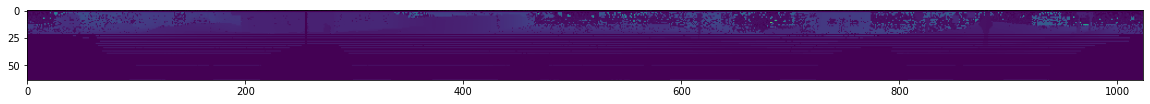

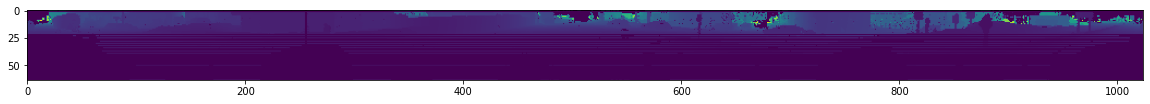

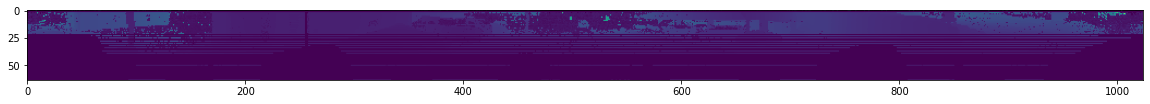

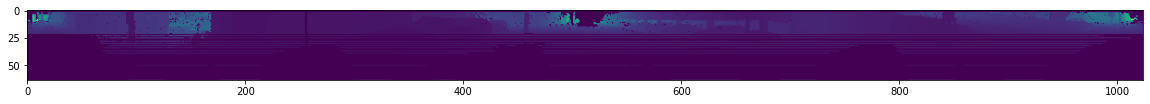

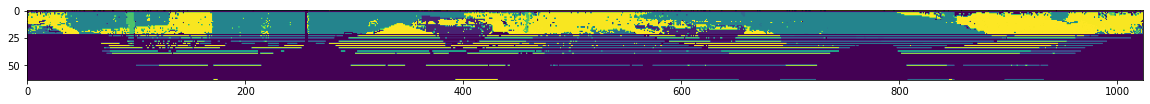

In [5]:
def display_loader(loader, plot_dim:int=1):
    x,y,*rest = next(iter(loader))
    plt.figure(figsize=(20, 6))
    plt.imshow(x[0,plot_dim,:,:]);
    plt.figure(figsize=(20, 6))
    plt.imshow(y[0,plot_dim,:,:]);
    if rest:
        l, k = rest
        plt.figure(figsize=(20, 6))
        plt.imshow(l[0,0,:,:]);
        
display_loader(train_loader)
display_loader(test_loader)

## Build net

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

# Reference
# https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    net.apply(init_func)  # apply the initialization function <init_func>
    

def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids) # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net
    
############ Blocks ############
class ResContextBlock(nn.Module):
    def __init__(self, in_filters, out_filters, bias=True):
        super(ResContextBlock, self).__init__()
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        self.activ = nn.LeakyReLU()
        
        layers  = [nn.Conv2d(in_filters, out_filters, 1, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.skip_path = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(in_filters, out_filters, 5, padding=2, bias=bias)]
        layers += relu_and_norm()
        layers += [nn.Conv2d(out_filters, out_filters, 3, dilation=3, padding=3, bias=bias)]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        shortcut = self.skip_path(x)
        resA = self.block(x)
        out = self.activ(shortcut + resA)
        return out


class ResBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=3, stride=1,
                 pooling=True, drop_out:float=0.2, bias=True):
        super(ResBlock, self).__init__()
        self.pooling = pooling
        self.drop_out = drop_out
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        
        self.activ = nn.LeakyReLU()

        layers  = [nn.Conv2d(in_filters, out_filters, 1, stride=stride, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.skip_path = nn.Sequential(*layers)

        layers  = [nn.Conv2d(in_filters, out_filters, 3, padding=1, bias=bias)]
        layers += relu_and_norm()
        self.path1 = nn.Sequential(*layers)

        layers  = [nn.Conv2d(out_filters, out_filters, 3, dilation=2, padding=2, bias=bias)]
        layers += relu_and_norm()
        self.path2 = nn.Sequential(*layers)

        layers  = [nn.Conv2d(out_filters, out_filters, 2, dilation=2, padding=1, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.path3 = nn.Sequential(*layers)

        layers  = [nn.Conv2d(3*out_filters, out_filters, 1, bias=bias)]
        self.path4 = nn.Sequential(*layers)

        self.dropout = nn.Dropout2d(p=drop_out)
        if pooling:
            #self.pool = nn.AvgPool2d(kernel_size=kernel_size, stride=2, padding=1)
            layers  = [nn.PixelUnshuffle(2)]
            layers += [nn.Conv2d(4*out_filters, out_filters, 1, bias=bias)]
            layers += [nn.LeakyReLU()]
            self.pool = nn.Sequential(*layers)

    def forward(self, x):
        shortcut = self.skip_path(x)

        resA1 = self.path1(x)
        resA2 = self.path2(resA1)
        resA3 = self.path3(resA2)

        concat = torch.cat((resA1, resA2, resA3),dim=1)
        resA = self.path4(concat)
        resA += shortcut
        resA = self.activ(resA)

        resB = self.dropout(resA) if self.drop_out else resA

        if self.pooling:
            resB = self.pool(resB)
            return resB, resA
        return resB


class UpBlock(nn.Module):
    def __init__(self, in_filters, out_filters, drop_out:float=None):
        super(UpBlock, self).__init__()
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        
        layers  = [nn.PixelShuffle(2)]
        layers += [nn.Dropout2d(p=drop_out)] if drop_out else []
        self.up_path = nn.Sequential(*layers)

        layers  = [nn.Dropout2d(p=drop_out)] if drop_out else []
        layers += [nn.Conv2d(in_filters//4 + 2*out_filters, out_filters, 1, padding=0)]
        layers += relu_and_norm()
        self.path1 = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(out_filters, out_filters, 3, dilation=1, padding=1)]
        layers += [nn.LeakyReLU()]
        self.path2 = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(2*out_filters, out_filters, 1)]
        layers += relu_and_norm()
        layers += [nn.Dropout2d(p=drop_out)] if drop_out else []
        self.path4 = nn.Sequential(*layers)

    def forward(self, x, skip):
        upA = self.up_path(x) 
        upB = torch.cat((upA,skip),dim=1)
    
        upE1 = self.path1(upB)
        upE2 = self.path2(upE1)

        concat = torch.cat((upE1, upE2),dim=1)
        upE = self.path4(concat)
        return upE
    
############## U-net ##############   
class SalsaV2(nn.Module):
    def __init__(self, in_channels:int=2):
        super(SalsaV2, self).__init__()
        in_chnl = in_channels
        
        name2block = {
            'c'   :lambda i,o: nn.Conv2d(i, o, 5, padding=2),
            'sup' :lambda i,o: UpBlock(i, o, drop_out=False),
            'sdwn':lambda i,o: ResBlock(i, o, pooling=True,  drop_out=False),
            'sres':lambda i,o: ResBlock(i, o, pooling=False, drop_out=False),
            'cntx':lambda i,o: ResContextBlock(i, o),
        }
        
        layer_list = [
            'cntx-32', 'cntx-32', 'marker', # Pre process
            'sdwn-64', 'sdwn-128', 'sdwn-256', 'marker', # Encode
            'sres-256', 'marker', # Process features
            'sup-128', 'sup-64', 'sup-32', 'marker', # Decode
            'cntx-32', 'c-1', # Post process
        ]
        
        # Extract markers so we know where up/down layers start
        markers = [i for i,x in enumerate(layer_list) if x=='marker']
        markers = [x-i for i,x in enumerate(markers)]
        layer_list = [l for l in layer_list if l != 'marker']
        
        # Complie blocks
        layers = []
        for idx, layer in enumerate(layer_list):
            block_name, out_chnl = layer.split('-')
            out_chnl = int(out_chnl)
            layers += [name2block[block_name](in_chnl, out_chnl)]
            in_chnl = out_chnl
        
        # Assign names
        m = markers
        self.pre  = nn.Sequential(*layers[   0:m[0]])
        self.down =                layers[m[0]:m[1]]
        self.mid  = nn.Sequential(*layers[m[1]:m[2]])
        self.up   =                layers[m[2]:m[3]]
        self.post = nn.Sequential(*layers[m[3]:])
        
        self.dummy = nn.Sequential(*layers) # so pytorch can see the layers
        
    def forward(self, x):
        # Encode
        pre  = self.pre(x)
        skips = [pre]
        down = pre
        for d in self.down:
            down, skip = d(down)
            skips += [skip]
        mid = self.mid(down)
        skips = [*reversed(skips)] # decoders want reverse order
        
        # Decode
        up  = mid
        for u,s in zip(self.up, skips):
            up = u(up,s)
        out = self.post(up)
        return out
    
########## Mask ##############
class Masker(nn.Module):
    def __init__(self):
        super(Masker, self).__init__()
        self.net = SalsaV2(in_channels=2)
        
    def forward(self, x):
        m = self.net(x)
        m = (torch.tanh(m) + 1) / 2
        m = m * x.ge(0) # leverage that -1 -> 0
        return m
    
########### Impute ##########
class Imputer(nn.Module):
    def __init__(self):
        super(Imputer, self).__init__()
        self.net = SalsaV2(in_channels=5)
        
    def forward(self, x, m):
        snow_mask = m.ge(0.5).repeat(1, x.shape[1], 1, 1)
        snow = x * snow_mask
        back = x * ~snow_mask
        cat  = torch.cat([snow, back, m], dim=1)
        imp  = self.net(cat)
        out  = back + imp * snow_mask
        return out
    
########### Gen ##########
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.mask = SalsaV2(in_channels=2)
        self.imp  = SalsaV2(in_channels=6)
        
    def forward(self, x):
        # mask
        m = self.mask(x)
        m = (torch.tanh(m) + 1) / 2
        m = m * x.ge(0) # leverage that -1 -> 0
        
        # impute
        snow_mask = m.ge(0.5)
        snow = x * snow_mask
        back = x * ~snow_mask
        cat  = torch.cat([snow, back, m], dim=1)
        imp  = self.imp(cat)
        out  = back + imp * snow_mask
        return out, m
    
############## encoder ##############
class Encoder(nn.Module):
    def __init__(self, in_channels:int=2):
        super(Encoder, self).__init__()
        in_chnl = in_channels
        
        name2block = {
            'cntx': lambda i,o: ResContextBlock(i, o),
            'down': lambda i,o: ResBlock(i, o, pooling=True,  drop_out=False),
            'res' : lambda i,o: ResBlock(i, o, pooling=False, drop_out=False),
        }
        
        layer_list = [
            'cntx-32', 'cntx-32', 'marker', # Pre process
            'down-64', 'down-128', 'down-256', 'marker', # Encode
            'res-256', # Process features
        ]
        markers = [i for i,x in enumerate(layer_list) if x=='marker'] # Extract markers
        markers = [x-i for i,x in enumerate(markers)]
        layer_list = [l for l in layer_list if l != 'marker']
        
        layers = []
        for idx, layer in enumerate(layer_list):
            block_name, out_chnl = layer.split('-')
            out_chnl = int(out_chnl)
            layers += [name2block[block_name](in_chnl, out_chnl)]
            in_chnl = out_chnl
        
        m = markers
        self.pre  = nn.Sequential(*layers[   0:m[0]])
        self.down =                layers[m[0]:m[1]]
        self.post = nn.Sequential(*layers[m[1]:])
        
        self.dummy = nn.Sequential(*layers) # so pytorch can see the layers
        
    def forward(self, x):
        pre  = self.pre(x)
        skips = [pre]
        down = pre
        for d in self.down:
            down, skip = d(down)
            skips += [skip]
        latent = self.post(down)
        skips = [*reversed(skips)] # decoders want reverse order

        return latent, skips

############## Disc ##############
class Discriminator(nn.Module):
    def __init__(self, channels:int=256):
        super(Discriminator, self).__init__()
        self.encoder = Encoder()
        
        layers  = [nn.Conv2d(channels, channels, (1,1), padding=0, bias=False)]
        layers += [nn.LeakyReLU()]
        layers += [nn.Dropout(0.1)]
        layers += [nn.Conv2d(channels, 1, (8,128), padding=0, bias=False)]
        self.disc = nn.Sequential(*layers)
        
    def forward(self, x):
        latent, skips = self.encoder(x)
        d = self.disc(latent)
        return d
    

def summarise():
    print('Masker:')
    #summary(Masker().cuda(), (2, 64, 1024))
    print(info_summary(Masker().to(1), 
                       input_size=(1, 2, 64, 1024),
                       device=1,
                       verbose=0,
                       depth=5))
    print()
    print('Imputer:')
    #summary(Imputer().cuda(), (2, 64, 1024))
    print(info_summary(Imputer().to(1), 
                       input_size=[(1, 2, 64, 1024),(1, 1, 64, 1024)],
                       device=1,
                       verbose=0,
                       depth=5))
    print()
    print('Disc:')
    #summary(Discriminator().cuda(), (2, 64, 1024))
    print(info_summary(Discriminator().to(1), 
                       input_size=(1, 2, 64, 1024),
                       device=1,
                       verbose=0,
                       depth=5))
    
summarise()

Masker:
Layer (type:depth-idx)                             Output Shape              Param #
Masker                                             --                        --
├─SalsaV2: 1-1                                     [1, 1, 64, 1024]          --
│    └─Sequential: 2-1                             [1, 32, 64, 1024]         --
│    │    └─ResContextBlock: 3-1                   [1, 32, 64, 1024]         --
│    │    │    └─Sequential: 4-1                   [1, 32, 64, 1024]         --
│    │    │    │    └─Conv2d: 5-1                  [1, 32, 64, 1024]         96
│    │    │    │    └─LeakyReLU: 5-2               [1, 32, 64, 1024]         --
│    │    │    └─Sequential: 4-2                   [1, 32, 64, 1024]         --
│    │    │    │    └─Conv2d: 5-3                  [1, 32, 64, 1024]         1,632
│    │    │    │    └─LeakyReLU: 5-4               [1, 32, 64, 1024]         --
│    │    │    │    └─BatchNorm2d: 5-5             [1, 32, 64, 1024]         64
│    │    │    │    └─Co

## Train net

In [7]:
import torch.optim as optim
import torchvision.transforms as transforms
import itertools
import os
import cv2

# from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


class ToNumpy(object):
    def __call__(self, data):
        return data.cpu().detach().numpy().transpose(0, 2, 3, 1)


def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

######### Train #########
def train(train_loader, gen, disc, optimizerG, optimizerD, epoch, writer, config):
    
    bce = nn.BCEWithLogitsLoss(reduction='none')
    def loss(x, x_pred, y):
        l = bce(x_pred, y)
        # Exclude -1 paddings from loss
        l = l * x.ge(0).float().mean(dim=1).repeat(1, l.shape[1], 1, 1)
        return l.mean()
    
    gen.train()
    disc.train()
        
    for i, (dataA, dataB) in enumerate(train_loader):
            
        ## Train Masker (discriminator)
        for dA, dB in islice(train_loader, config['train']['disc_loops']):
            if config['run']['cuda']:
                dA = dA.to(config['run']['device'])
                dB = dB.to(config['run']['device'])
            
            set_requires_grad([disc], True)
            set_requires_grad([gen], False)
            optimizerD.zero_grad()
            
            # Forward 
            fake, mA = gen(dA)
            discF = disc(fake)
            discB = disc(dB)
            
            # Loss
            loss_disc  = bce(discF, torch.ones_like(discF))
            loss_disc += bce(discB, torch.zeros_like(discB))
            
            loss_disc.backward()
            nn.utils.clip_grad_norm_(disc.parameters(), 5)
            optimizerD.step()
            
        ## Train Masker (generator)
                    
        
        ## Train imputer and masker (generator)
        if config['run']['cuda']:
            dataA = dataA.to(config['run']['device'])
            dataB = dataB.to(config['run']['device'])
            
        set_requires_grad([disc], False)
        set_requires_grad([gen], True)
        optimizerG.zero_grad()
        
        # Forward
        fake, mA = gen(dataA)
        _,    mB = gen(dataB)
        discF = disc(fake)

        # loss
        loss_gen  = 1.0 * bce(discF, torch.zeros_like(discF))
        #loss_gen += 1.0 * mB[dataB.ge(0)].mean()
        loss_gen.backward()
        nn.utils.clip_grad_norm_(gen.parameters(), 5)
        optimizerG.step()
        
        ## Log train info
        toNumpy = lambda x: x.cpu().detach().numpy()
        dataB, fake = toNumpy(dataB), toNumpy(fake)
        span = 255 # manually set! dataA.max() sort of works if unkown
        # mean of funcion f applied to each channel for each image in batch
        apply = lambda f: np.mean([f(d, r, data_range=span) for da,ra in zip(dataB, fake) for d,r in zip(da,ra)])
        metrics = {
            'Loss_disc':loss_disc.item(),
            'Loss_gen':loss_gen.item(),
            #'psnr_A': apply(psnr),
            'ssim_A': apply(ssim),
        }
        iteration = len(train_loader)*(epoch-1)+i
        for k,v in metrics.items():
            writer.add_scalars(k, {config['train']['log_name']:v}, iteration)
        
        # Display train info
        print(f'\r[Epoch: {epoch:4d}][{1+i:4d}]',
              *[f'{k}: {v:.4f},' for k,v in metrics.items()],
              end=' '*10)

        # Create checkpoint
        if config['train']['checkpoint']:
            if i % config['train']['checkpoint'] == 0:
                if not os.path.isdir('E:/cyclegan/checkpoints'):
                    os.mkdir('E:/cyclegan/checkpoints')

                torch.save({
                    'generator': generator.state_dict(),
                    'optimizer': optimizerG.state_dict(),
                    'start_epoch': epoch,
                }, './runs/model_{}_{}.pth'.format(epoch, i))

######### Eval #########
def evaluation(test_loader, gen, disc, config):
    gen.eval()
    disc.eval()

    transform_inv = transforms.Compose([UnNormalize(mean=(0.0, 0.0), std=(1.0, 1.0)), ToNumpy()])
    toNumpy = lambda x: x.cpu().detach().numpy()
    def accuracy(x,y,**kwargs):
        return (np.round(x)==y).mean()
    tot_metrics = {}
        
    saved = 0
    with torch.no_grad():
        for i, (dataA, dataB, labels, keys) in enumerate(test_loader):
            
            if config['run']['cuda']:
                dataA = dataA.to(config['run']['device'])
                dataB = dataB.to(config['run']['device'])

            # forward
            fake, mA = gen(dataA)
            genB, mB = gen(dataB)
            discF = disc(fake)
            discB = disc(genB)
            
            # Display eval info
            toNumpy = lambda x: x.cpu().detach().numpy()
            np_dB, np_gB = toNumpy(dataB), toNumpy(fake)
            span = 255 # manually set! data.max() sort of works if unkown
            # mean of funcion f applied to each channel for each image in batch
            apply = lambda f: np.mean([f(d, r, data_range=span) for da,ra in zip(np_dB, np_gB) for d,r in zip(da,ra)])
            metrics = { 
                'x_mean': fake.mean(),
                'y_mean': dataB.mean(),
                'maskA' : mA.mean(),
                'maskB' : mB.mean(),
                #'psnr_A': apply(psnr),
                'ssim_A': apply(ssim),
                'acc'   : apply(accuracy)
            }
            tot_metrics = {k:tot_metrics.get(k,0) + v for k,v in metrics.items()}
            print(f'\r[Eval Iter: {1+i:4d}]',
                  *[f'{k}: {v/(1+i):.4f},' for k,v in tot_metrics.items()],
                  end=' '*10)
            
            # Log eval info
            mA[:,1] = dataA[:,1] # add range value to mask for 3d
            data = {'input':dataA, 
                    'out':fake,
                    'mask':mA}
            data = {k:transform_inv(v) for k,v in data.items()}

            if saved < config['eval']['save']:
                if not os.path.isdir('results'):
                    os.mkdir('results')
                
                max_saves = config['eval']['save'] - saved
                batch_size = dataA.shape[0]
                for j in range(0, min(batch_size, max_saves)):
                    number = batch_size * i + j
                    saved += 1
                    for k,image in data.items():
                        name = f'{k}_{number:0>4d}'
                        (*folder_id,), (*file_name,) = keys
                        save_data('./results', name, image[j], labels[j], (folder_id[j],file_name[j]) )
                        
    
def save_data(folder, name, projection, labels=None, keys:tuple=None):
    "Saves a 2d and an unprojected 3d image"
    
    def normalize(img):
        i = img.copy()
        power = 1/4 # prevents extremes from using the full pallete
        i[i<0] = -np.power(-i[i<0],power)
        i[i>0] =  np.power( i[i>0],power)
        i -= i.min()
        return i / i.max()
    
    # make 2d image  
    x = projection
    img = np.concatenate([normalize(x[:,:,i]) for i in range(x.shape[2])], axis=0)
    
    if not os.path.isdir('./results/2d'):
        os.mkdir('./results/2d')
    plt.imsave(folder+'/2d/'+name+'.png', img)
    
    if keys: # make 3d image
        folder_id, file_name = keys
        folder = folder+'/'+'_'.join(name.split('_')[:1])
        points, mask = unproject(projection, return_mask=True)
        frame = {file_name:points}
        
        label = labels
        if label != None:
            # Flatten labels the same way unprojection is done
            channel, height, width = labels.shape
            label = -np.ones((height*width, channel), dtype=np.int16)
            l = labels.detach().cpu().numpy()
            for y,x in product(range(height), range(width)):
                index = y*width+x
                label[index] = l[:,y,x]
            label = {file_name:label[mask]}
        write_one_kitty(folder, frame, labels=label)
        
######### Main #########
def main():
    checkpoint = None
    do_train = True
    config = yaml.safe_load(open('./net_config.yaml'))
    
    torch.manual_seed(config['run']['seed'])
    torch.cuda.manual_seed(config['run']['seed'])
    np.random.seed(config['run']['seed'])
    
    gen  = Generator()
    disc = Discriminator()

    if config['run']['cuda']:
        gen = gen.to(config['run']['device'])
        disc = disc.to(config['run']['device'])
    
    optimizerG = optim.Adam(
        itertools.chain(gen.parameters()), 
        lr=config['generator']['lr'], 
        betas=(0.5, 0.9),
        amsgrad=True)
    
    optimizerD = optim.Adam(
        itertools.chain(disc.parameters()), 
        lr=config['discriminator']['lr'], 
        betas=(0.5, 0.9),
        amsgrad=True)

    if checkpoint:
        path = 'E:/cyclegan/checkpoints/model_{}_{}.pth'.format(285, 200)

        checkpoint = torch.load(path)
        encoder.load_state_dict(checkpoint['gen'])
        decoder.load_state_dict(checkpoint['disc'])
        optimizer.load_state_dict(checkpoint['optimizer'])

        start_epoch = 285
    else:
        for net in [gen, disc]:
            init_net(net, init_type='kaiming', init_gain=0.02, gpu_ids=[config['run']['device']])
        start_epoch = 1

    if do_train:
        writer = SummaryWriter('results/'+'logs')
        for epoch in range(start_epoch, config['train']['max_epoch']+1):
            train(train_loader, gen, disc, optimizerG, optimizerD, epoch, writer, config)
            print()
        writer.close()
        
    evaluation(test_loader, gen, disc, config)
    print()

main()

[Epoch:    1][ 130] Loss_disc: 0.0000, Loss_gen: 104.9939, ssim_A: 0.7605,            
[Epoch:    2][ 130] Loss_disc: 0.0000, Loss_gen: 134.0927, ssim_A: 0.6720,          
[Epoch:    3][ 130] Loss_disc: 0.0000, Loss_gen: 104.1278, ssim_A: 0.7086,          
[Epoch:    4][ 130] Loss_disc: 0.0000, Loss_gen: 76.5848, ssim_A: 0.7786,           
[Epoch:    5][ 130] Loss_disc: 0.0000, Loss_gen: 130.5938, ssim_A: 0.7907,          
[Epoch:    6][ 130] Loss_disc: 0.0000, Loss_gen: 443.7490, ssim_A: 0.8465,          
[Epoch:    7][ 130] Loss_disc: 0.0000, Loss_gen: 336.4749, ssim_A: 0.7824,          
[Epoch:    8][ 130] Loss_disc: 0.0000, Loss_gen: 348.6630, ssim_A: 0.8206,          
[Epoch:    9][ 130] Loss_disc: 0.0000, Loss_gen: 329.5497, ssim_A: 0.8095,          
[Epoch:   10][ 130] Loss_disc: 0.0000, Loss_gen: 389.8749, ssim_A: 0.8587,          
[Epoch:   11][ 130] Loss_disc: 0.0000, Loss_gen: 405.4541, ssim_A: 0.8109,          
[Epoch:   12][ 130] Loss_disc: 0.0000, Loss_gen: 326.8093, ssim

In [9]:
!zip -r ./results/results.zip ./results/input ./results/out ./results/2d > /dev/null

In [ ]:
!tensorboard --logdir="results/logs" --port=6060